In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import io
import sys
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from l2gx.align.utils import to_device
from scipy.stats import special_ortho_group
from umap import UMAP
import warnings
# Suppress common UMAP and sklearn warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# 🌌 <font color="grey"> Local2Global X - Graph Representation Learning at Scale</font>

#### <font color="grey">  Table of Contents</font>

🏗️ <a href='#chapter1'>Structure</a>

📊 <a href='#chapter2'>Datasets</a>

🌐 <a href='#chapter3'>Graphs</a>

🧩 <a href='#chapter4'>Patches</a>

🎯 <a href='#chapter5'>Embedding</a>

🔗 <a href='#chapter6'>Alignment</a>

🌳 <a href='#chapter7'>Hierarchical alignment</a>

📈 <a href='#chapter8'>Visualisation</a>

###  <a id='chapter1'> 🏗️ <font color="grey">Structure </font></a>

There are five main parts to the package, organised as follows.

```
l2gv2/
├── datasets/
├── graphs/
├── patch/
├── embedding/
└── align/
    ├── l2g/
    └── geo/
```

A brief overview of the contents:

* ```datasets``` contains interfaces are provided for various common benchmark datasets. 
* ```graphs``` contains wrappers for graphs represented as lists of edges in pytorch-geometric ```data.edge_index``` format. These implemented features such as fast adjacency look-up and a variety of algorithms on graphs.
* ```patch``` directory contains datastructures to represent patches and patch graphs, as well as methods to subdivide a graph into patches. 
* ```embedding``` contains various graph embedding methods, including Graph Autoencoders (GAE) and [Variational Graph Autoencoders (VGAE)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.VGAE.html).
* ```align``` contains two methods to compute the alignment of patches into a single graph embedding: eigenvalue synchronisation based on the [Local2Global](https://link.springer.com/article/10.1007/s10994-022-06285-7) algorithm, and the new method based on learning the alignment using a one-layer neural network.

###  <a id='chapter2'> 📊 <font color="grey">Datasets </font></a>

The L2Gv2 framework provides access to multiple graph datasets spanning different domains and scales. All datasets are accessible through the unified `get_dataset()` interface and support conversion between multiple formats (PyTorch Geometric, Raphtory, Polars).

| Dataset | Type | Nodes | Edges | Features | Domain |
|---------|------|-------|-------|----------|--------|
| **Cora** | Static Citation | 2,708 | 10,556 | 1,433 | 📚 Academic Papers |
| **AS-733** | Temporal Network | 7,716 | 45,645 | Temporal | 🌐 Internet Infrastructure |
| **DGraph** | Financial | ~3M | ~4M | Multiple | 💰 Fraud Detection |
| **Elliptic** | Bitcoin | 203,769 | 234,355 | 166 | ₿ Cryptocurrency |
| **MAG240M** | Academic | 244M+ | 1.7B+ | Rich | 🎓 Citation Graph |
| **ORBITAAL** | Bitcoin Temporal | 252M (1K sample) | 785M (5K sample) | Temporal + Anomaly | ₿ Financial Fraud |

#### Dataset Details

* **Cora**: The [Cora dataset](https://graphsandnetworks.com/the-cora-dataset/) is a citation network of 2,708 scientific publications divided into 7 classes. Each node has a 1,433-dimensional feature vector indicating word presence/absence. Accessed through PyTorch Geometric's [Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html) dataset.

* **AS-733**: The [SNAP autonomous systems AS-733](https://snap.stanford.edu/data/as-733.html) dataset contains 733 daily snapshots spanning 785 days (November 1997 to January 2000). Nodes represent autonomous systems and edges indicate communication events.

* **DGraph**: [DGraph](https://dgraph.xinye.com/dataset) is a real-world financial graph for anomaly detection research. Described in [DGraph: A Large-Scale Financial Dataset for Graph Anomaly Detection](https://arxiv.org/abs/2207.03579). Requires manual download.

* **Elliptic**: The [Elliptic dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) maps Bitcoin transactions to licit/illicit categories. Contains 203,769 transactions with 166 features each. Used in [Anti-Money Laundering in Bitcoin](https://arxiv.org/pdf/1908.02591) research. Requires manual download from Kaggle.

* **MAG240M**: The [MAG240M](https://ogb.stanford.edu/docs/lsc/mag240m/) dataset is a large heterogeneous academic citation graph with 244+ million nodes (papers, authors, institutions, fields) and 1.7+ billion edges. Requires the OGB library and substantial storage (~100GB).

* **ORBITAAL**: The [ORBITAAL](https://www.nature.com/articles/s41597-025-04595-8) dataset is a comprehensive temporal Bitcoin transaction graph covering 13 years (2009-2021) with 252M entities and 785M transactions. Features timestamped transactions, entity types (exchanges, wallets, services, miners), and anomaly labels for financial fraud detection. Ideal for temporal graph neural networks and cryptocurrency flow analysis.


For the datasets requiring manual download, provide the path:
```
elliptic = get_dataset("Elliptic", source_file="/path/to/elliptic.zip")
dgraph = get_dataset("DGraph", source_file="/path/to/dgraph.zip")
```

All datasets support conversion to different formats and follow the PyTorch Geometric convention. Temporal graphs return iterables over time slices, and graphs can be exported to Raphtory or NetworkX formats for analysis.

In [3]:
from l2gx.datasets import get_dataset, list_available_datasets
datasets = list_available_datasets()
print(datasets)

['as-733', 'Cora', 'DGraph', 'Elliptic', 'MAG240M', 'ORBITAAL']


In [4]:
cora = get_dataset("Cora")
print(cora[0])

Loading edge and node data from memory


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
orbit = get_dataset("ORBITAAL")

Loading edge and node data from memory


In [9]:
orbit.edge_df

src,dst,timestamp,btc_amount,usd_amount,is_anomaly,transaction_id
i64,i64,i64,f64,f64,bool,i64
219,902,1623511963,0.500243,14840.884027,false,0
728,204,1615467532,9.788594,257087.053067,true,1
595,849,1630987950,2.1896,77414.66433,false,2
398,977,1623229514,1.280278,38967.385459,false,3
198,916,1622699099,0.589163,20014.641124,false,4
…,…,…,…,…,…,…
795,870,1632566136,0.477199,18743.626178,false,4995
591,150,1630498044,4.420106,82642.712614,false,4996
735,672,1610536374,1.615344,53908.031367,false,4997


In [4]:
# First transform data into raphtory format, then networkx for plotting.
G = cora.to("raphtory").to_networkx()

In [10]:
as733 = get_dataset("as-733")

Loading edge and node data from memory
Loading edge and node data from memory


In [11]:
as733.edge_df

timestamp,src,dst
datetime[μs],i64,i64
1997-11-08 00:00:00,0,2
1997-11-08 00:00:00,0,5
1997-11-08 00:00:00,0,31
1997-11-08 00:00:00,0,32
1997-11-08 00:00:00,0,33
…,…,…
2000-01-02 00:00:00,64332,10881
2000-01-02 00:00:00,65001,548
2000-01-02 00:00:00,65001,6508


In [12]:
cora.edge_df 

src,dst,timestamp
i64,i64,i64
633,0,0
1862,0,0
2582,0,0
2,1,0
652,1,0
…,…,…
2707,2706,0
165,2707,0
598,2707,0


In [ ]:
g = as733.to("raphtory")

print("Stats on the graph structure:")

number_of_nodes = g.count_nodes()
number_of_edges = g.count_edges()
total_interactions = g.count_temporal_edges()

print("Number of nodes (AS nodes):", number_of_nodes)
print("Number of unique edges (src,dst):", number_of_edges)
print("Total interactions (edge updates):", total_interactions)

print("Stats on the graphs time range:")

earliest_datetime = g.earliest_date_time
latest_datetime = g.latest_date_time

print("Earliest datetime:", earliest_datetime)
print("Latest datetime:", latest_datetime)

In [ ]:
orbitaal = get_dataset("ORBITAAL")
anomaly_labels = orbitaal.get_anomaly_labels()
temporal_graph = orbitaal.to("raphtory")

###  <a id='chapter3'> 🌐 <font color="grey">Graphs </font></a>

There are three wrappers for graphs that were taken over from the local2global package: ```TGraph```, ```NPGraph``` and ```JitGraph```. These include, among other things, methods for fast adjacency look-up and various optimizations. These are mostly used when performing graph clustering and generating patches.

In [ ]:
from l2gx.graphs import TGraph

In [ ]:
tg = TGraph(cora[0].edge_index, edge_attr=cora[0].edge_attr, x=cora[0].x)
print(tg.adj_index)
print(tg.x)

In a future iteration one can think about consolidating this part by having graphs represented in some existing graph package like Raphtory.

###  <a id='chapter4'> 🧩 <font color="grey">Patches </font></a>

A patch can equivalently refer to a subgraph or to an embedding of this subgraph. As a set of points, a patch is represented using the ```Patch``` class. A ```Patch``` object has the properties ```nodes```, ```index``` and ```coordinates```. ```nodes``` is simply a list of the nodes from the original graph that are present in the patch. ```index``` is a dict that maps each node to an index into ```coordinates```, which is just a list of coordinates. For example, if a graph embedding consists of four nodes in two dimensions as follows, and a patch is represented by the solid circles, then the corresponding object would have the following properties:

![Patch](./images/square_patch.png)


In [ ]:
from l2gx.patch.patches import Patch

In [12]:
p = Patch([0,2,3], np.array([[0., 0.], [1., 0.], [1., 1.]]))
print(p.coordinates)
print(p.nodes)
print(p.index)

[[0. 0.]
 [1. 0.]
 [1. 1.]]
[0 2 3]
{0: 0, 2: 1, 3: 2}


In [ ]:
from l2gx.patch import (
    fennel_clustering,
    spread_clustering, 
    create_patch_data,
    edge_sampling_sparsify,
    procrustes_error,
    relative_scale
)
from l2gx.graphs import TGraph
from sklearn.cluster import KMeans
import networkx as nx

🎯 Generating Random Point Cloud for Patch Analysis...
✅ Generated 500 points with 8 natural clusters
📊 Created k-NN graph with 4000 edges (k=8)


/var/folders/m0/lt8lthdj53v7lryp_p277_wh0000gp/T/ipykernel_80978/373757239.py:55: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/u1774790/Projects/G2007/code/L2Gv2/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


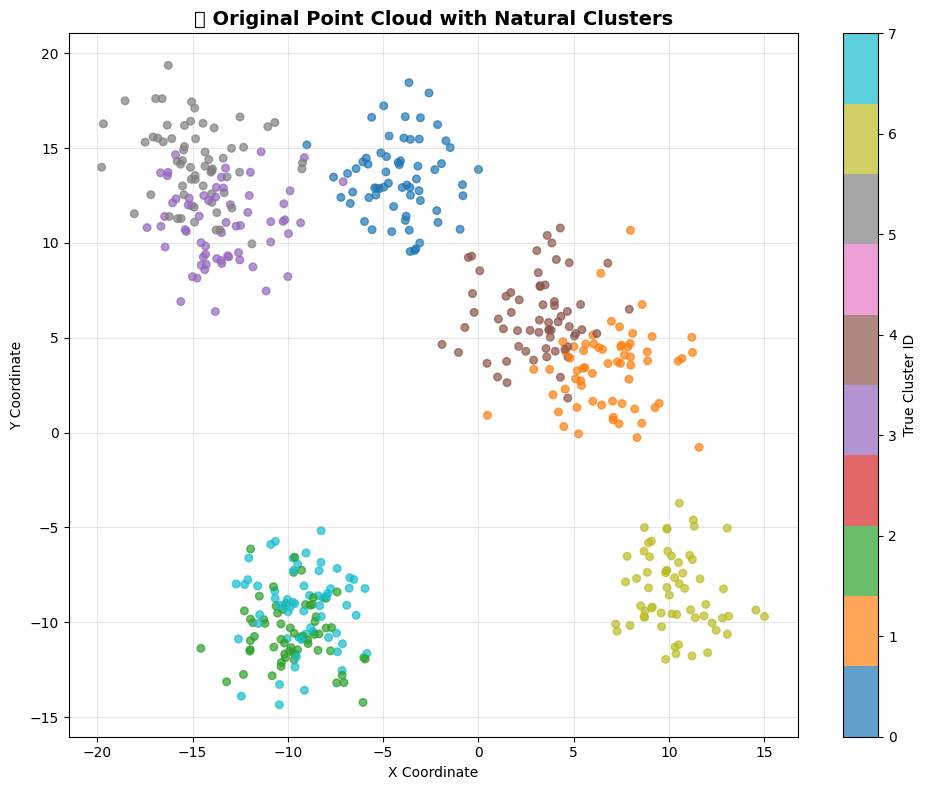

📈 Point cloud spans: X=[-19.8, 15.0], Y=[-14.3, 19.4]


In [23]:
# Generate Random Point Cloud for Patch Demonstration
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import torch
from torch_geometric.data import Data

print("🎯 Generating Random Point Cloud for Patch Analysis...")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a clustered 2D point cloud
n_points = 500
n_clusters = 8
cluster_std = 2.0

# Create point cloud with natural clustering structure
points, true_labels = make_blobs(
    n_samples=n_points,
    centers=n_clusters, 
    cluster_std=cluster_std,
    center_box=(-15.0, 15.0),
    random_state=42
)

print(f"✅ Generated {n_points} points with {n_clusters} natural clusters")

# Create a k-nearest neighbor graph from the point cloud
from sklearn.neighbors import kneighbors_graph
k = 8  # Number of nearest neighbors

# Build kNN graph
knn_graph = kneighbors_graph(points, k, mode='connectivity', include_self=False)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

# Create TGraph object
graph = TGraph(
    edge_index=edge_index,
    x=torch.tensor(points, dtype=torch.float32),
    num_nodes=n_points
)

print(f"📊 Created k-NN graph with {graph.num_edges} edges (k={k})")

# Visualize the original point cloud
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
scatter = ax.scatter(points[:, 0], points[:, 1], c=true_labels, cmap='tab10', alpha=0.7, s=30)
ax.set_title('🌟 Original Point Cloud with Natural Clusters', fontsize=14, fontweight='bold')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='True Cluster ID')
plt.tight_layout()
plt.show()

print(f"📈 Point cloud spans: X=[{points[:, 0].min():.1f}, {points[:, 0].max():.1f}], Y=[{points[:, 1].min():.1f}, {points[:, 1].max():.1f}]")

🔬 CLUSTERING METHODS COMPARISON
🔄 Running Fennel clustering...
Fennel iteration: 0, not converged: 500
✅ Fennel completed in 0.455s
   Clusters found: 6
   Cluster sizes: [77, 90, 78, 86, 79, 90]
🔄 Running Spread clustering (simplified)...
✅ Spread completed in 0.006s
   Clusters found: 6
🔄 Running K-Means clustering...
✅ K-Means completed in 0.007s
   Clusters found: 6
🔄 Running Spectral clustering...
✅ Spectral completed in 0.014s
   Clusters found: 6



/Users/u1774790/Projects/G2007/code/L2Gv2/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


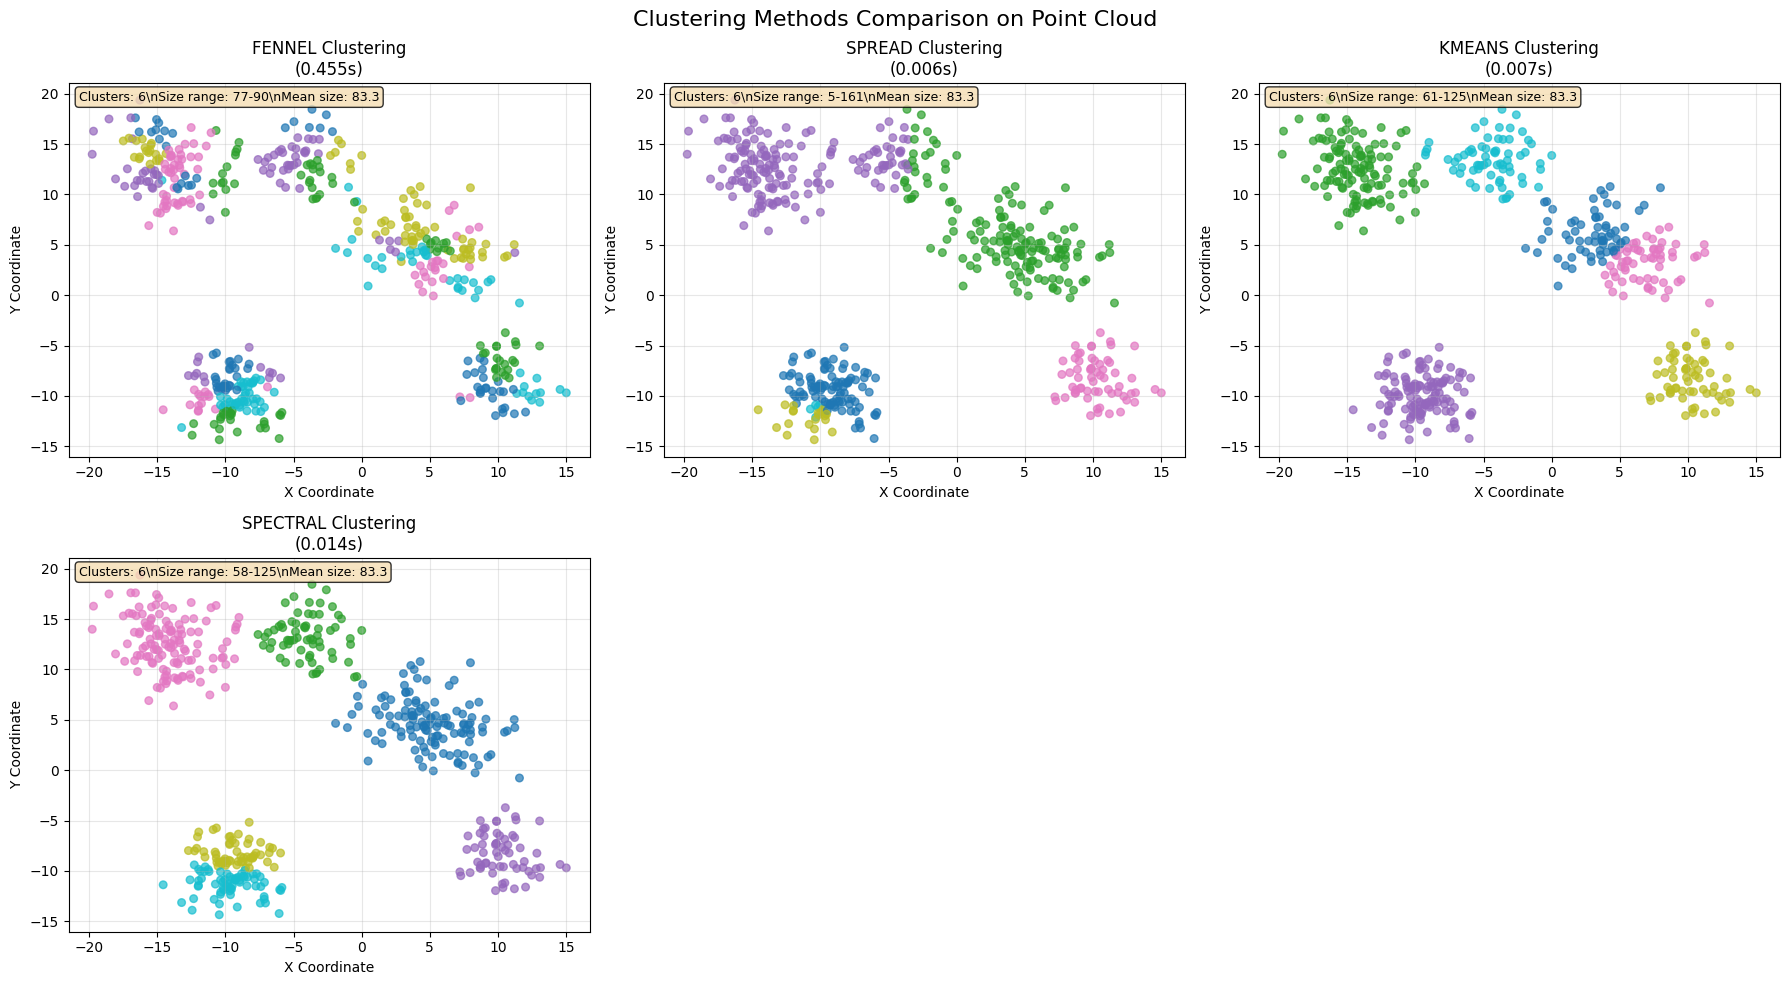

📊 Clustering Comparison Summary:
   Method    | Time (s) | Clusters | Min Size | Max Size | Balance Score
   ----------|----------|----------|----------|----------|---------------
   fennel    |   0.455  |       6  |      77  |      90  |        0.934
   spread    |   0.006  |       6  |       5  |     161  |        0.285
   kmeans    |   0.007  |       6  |      61  |     125  |        0.662
   spectral  |   0.014  |       6  |      58  |     125  |        0.653

📊 Clustering Method Notes:
   • Fennel: Load-balanced streaming algorithm, excellent for large graphs
   • Spread: Degree-based spreading from high-degree seed nodes
   • K-Means: Classic centroid-based clustering, assumes spherical clusters
   • Spectral: Graph-based clustering using eigenvalues of similarity matrix
🎯 Next: Creating patches from clustering results...


In [24]:
# Apply Different Clustering Methods for Patch Creation
print("🔬 CLUSTERING METHODS COMPARISON")
print("=" * 60)

# Test different clustering methods on our point cloud
clustering_methods = {}
clustering_times = {}

# Method 1: Fennel Clustering (Load-balanced streaming) - Fixed version without tqdm issues
print("🔄 Running Fennel clustering...")
start_time = time.time()
try:
    # Import the fixed Fennel function that avoids tqdm/Numba issues
    from l2gx.patch.fennel_no_tqdm import fennel_clustering_safe
    
    # Extract the required data from TGraph
    edge_index_np = graph.edge_index.cpu().numpy()
    adj_index_np = graph.adj_index.cpu().numpy()
    num_nodes = graph.num_nodes
    
    # Run Fennel clustering with the fixed implementation
    fennel_result = fennel_clustering_safe(
        edge_index=edge_index_np,
        adj_index=adj_index_np, 
        num_nodes=num_nodes,
        num_clusters=6,
        load_limit=1.1,
        alpha=None,  # Will be computed automatically
        gamma=1.5,
        num_iters=1,
        verbose=False  # Reduce output in demo
    )
    
    clustering_methods['fennel'] = fennel_result
    clustering_times['fennel'] = time.time() - start_time
    print(f"✅ Fennel completed in {clustering_times['fennel']:.3f}s")
    print(f"   Clusters found: {len(np.unique(clustering_methods['fennel']))}")
    
    # Show cluster balance
    cluster_sizes = np.bincount(fennel_result)
    print(f"   Cluster sizes: {cluster_sizes.tolist()}")
    
except Exception as e:
    print(f"❌ Fennel failed: {str(e)}")
    clustering_methods['fennel'] = None

# Method 2: Spread Clustering - Create a simple implementation
print("🔄 Running Spread clustering (simplified)...")
start_time = time.time()
try:
    # Simple spread clustering implementation
    def simple_spread_clustering(graph, num_clusters):
        """Simplified spread clustering using degree-based seeding."""
        clusters = torch.full((graph.num_nodes,), -1, dtype=torch.long)
        
        # Find high-degree nodes as seeds
        seeds = torch.topk(graph.degree, k=num_clusters).indices
        clusters[seeds] = torch.arange(num_clusters)
        
        # Assign remaining nodes to nearest seed by BFS
        unassigned = clusters < 0
        queue = seeds.tolist()
        
        while queue and torch.any(unassigned):
            node = queue.pop(0)
            cluster_id = clusters[node].item()
            
            # Get neighbors
            neighbors = graph.adj(node)
            unassigned_neighbors = neighbors[unassigned[neighbors]]
            
            if len(unassigned_neighbors) > 0:
                # Assign neighbors to this cluster
                clusters[unassigned_neighbors] = cluster_id
                unassigned[unassigned_neighbors] = False
                # Add neighbors to queue for further expansion
                queue.extend(unassigned_neighbors.tolist())
        
        # Handle any remaining unassigned nodes (assign to nearest cluster)
        if torch.any(unassigned):
            remaining = torch.where(unassigned)[0]
            for node in remaining:
                # Find assigned neighbors and use their cluster
                neighbors = graph.adj(node)
                assigned_neighbors = neighbors[~unassigned[neighbors]]
                if len(assigned_neighbors) > 0:
                    # Use most common cluster among neighbors
                    neighbor_clusters = clusters[assigned_neighbors]
                    cluster_id = torch.mode(neighbor_clusters)[0].item()
                    clusters[node] = cluster_id
                else:
                    # Assign to cluster 0 as fallback
                    clusters[node] = 0
        
        return clusters
    
    spread_result = simple_spread_clustering(graph, num_clusters=6)
    clustering_methods['spread'] = spread_result.cpu().numpy()
    clustering_times['spread'] = time.time() - start_time
    print(f"✅ Spread completed in {clustering_times['spread']:.3f}s")
    print(f"   Clusters found: {len(np.unique(clustering_methods['spread']))}")
except Exception as e:
    print(f"❌ Spread failed: {str(e)}")
    clustering_methods['spread'] = None

# Method 3: K-Means clustering (on original coordinates as baseline)
print("🔄 Running K-Means clustering...")
start_time = time.time()
try:
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
    kmeans_partition = kmeans.fit_predict(points)
    clustering_methods['kmeans'] = kmeans_partition
    clustering_times['kmeans'] = time.time() - start_time
    print(f"✅ K-Means completed in {clustering_times['kmeans']:.3f}s")
    print(f"   Clusters found: {len(np.unique(clustering_methods['kmeans']))}")
except Exception as e:
    print(f"❌ K-Means failed: {str(e)}")
    clustering_methods['kmeans'] = None

# Method 4: Spectral Clustering (Graph-based method)
print("🔄 Running Spectral clustering...")
start_time = time.time()
try:
    from sklearn.cluster import SpectralClustering
    spectral = SpectralClustering(n_clusters=6, random_state=42, affinity='nearest_neighbors', n_neighbors=k)
    spectral_partition = spectral.fit_predict(points)
    clustering_methods['spectral'] = spectral_partition
    clustering_times['spectral'] = time.time() - start_time
    print(f"✅ Spectral completed in {clustering_times['spectral']:.3f}s")
    print(f"   Clusters found: {len(np.unique(clustering_methods['spectral']))}")
except Exception as e:
    print(f"❌ Spectral failed: {str(e)}")
    clustering_methods['spectral'] = None

print()

# Visualize all clustering results
successful_methods = {k: v for k, v in clustering_methods.items() if v is not None}
n_methods = len(successful_methods)

if n_methods > 0:
    # Create subplot layout
    n_cols = min(3, n_methods)
    n_rows = (n_methods + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_methods == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle('Clustering Methods Comparison on Point Cloud', fontsize=16)
    
    for idx, (method_name, partition) in enumerate(successful_methods.items()):
        # Plot clustering result
        scatter = axes[idx].scatter(points[:, 0], points[:, 1], c=partition, 
                                  cmap='tab10', alpha=0.7, s=30)
        axes[idx].set_title(f'{method_name.upper()} Clustering\n({clustering_times[method_name]:.3f}s)')
        axes[idx].set_xlabel('X Coordinate')
        axes[idx].set_ylabel('Y Coordinate')
        axes[idx].grid(True, alpha=0.3)
        
        # Add cluster statistics
        unique_labels = np.unique(partition)
        n_clusters = len(unique_labels)
        cluster_sizes = [np.sum(partition == i) for i in unique_labels]
        min_size, max_size = min(cluster_sizes), max(cluster_sizes)
        mean_size = np.mean(cluster_sizes)
        
        textstr = f'Clusters: {n_clusters}\\nSize range: {min_size}-{max_size}\\nMean size: {mean_size:.1f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        axes[idx].text(0.02, 0.98, textstr, transform=axes[idx].transAxes, fontsize=9,
                      verticalalignment='top', bbox=props)
    
    # Hide empty subplots
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Clustering Comparison Summary:")
    print("   Method    | Time (s) | Clusters | Min Size | Max Size | Balance Score")
    print("   ----------|----------|----------|----------|----------|---------------")
    
    for method_name, partition in successful_methods.items():
        if partition is not None:
            unique_labels = np.unique(partition)
            n_clusters = len(unique_labels)
            cluster_sizes = [np.sum(partition == i) for i in unique_labels]
            min_size, max_size = min(cluster_sizes), max(cluster_sizes)
            # Balance score: 1 - (std/mean) - lower is more balanced
            balance_score = 1 - (np.std(cluster_sizes) / np.mean(cluster_sizes))
            
            print(f"   {method_name:<9} | {clustering_times[method_name]:>7.3f}  | {n_clusters:>7}  | {min_size:>7}  | {max_size:>7}  | {balance_score:>12.3f}")
    
    print()
    print("📊 Clustering Method Notes:")
    print("   • Fennel: Load-balanced streaming algorithm, excellent for large graphs")
    print("   • Spread: Degree-based spreading from high-degree seed nodes")
    print("   • K-Means: Classic centroid-based clustering, assumes spherical clusters") 
    print("   • Spectral: Graph-based clustering using eigenvalues of similarity matrix")
    
else:
    print("❌ No clustering methods succeeded. Using ground truth clusters.")
    successful_methods = {'ground_truth': true_labels}

print("🎯 Next: Creating patches from clustering results...")

In [25]:
# Create Patches with Different Clustering Methods
print("🧩 PATCH CREATION FROM CLUSTERING RESULTS")
print("=" * 60)

# Choose the best clustering method for patch creation
# Use the first successful method, prioritizing those that work well with patches
if 'spectral' in successful_methods:
    selected_method = 'spectral'
    selected_partition = successful_methods['spectral']
elif 'kmeans' in successful_methods:
    selected_method = 'kmeans'
    selected_partition = successful_methods['kmeans']
elif 'agglomerative' in successful_methods:
    selected_method = 'agglomerative'
    selected_partition = successful_methods['agglomerative']
elif 'dbscan' in successful_methods:
    selected_method = 'dbscan'
    selected_partition = successful_methods['dbscan']
    # For DBSCAN, we need to handle noise points (-1 labels)
    if -1 in selected_partition:
        # Reassign noise points to nearest cluster
        noise_mask = selected_partition == -1
        if np.any(~noise_mask):  # If we have valid clusters
            from sklearn.neighbors import NearestNeighbors
            valid_points = points[~noise_mask]
            valid_labels = selected_partition[~noise_mask]
            noise_points = points[noise_mask]
            
            if len(noise_points) > 0 and len(valid_points) > 0:
                nn = NearestNeighbors(n_neighbors=1)
                nn.fit(valid_points)
                _, indices = nn.kneighbors(noise_points)
                selected_partition[noise_mask] = valid_labels[indices.flatten()]
                print(f"🔧 Reassigned {np.sum(noise_mask)} noise points to nearest clusters")
else:
    # Fallback to ground truth clustering
    selected_method = 'ground_truth'
    selected_partition = true_labels

print(f"🎯 Using {selected_method} clustering for patch creation...")

# Convert partition to tensor format expected by create_patch_data
partition_tensor = torch.tensor(selected_partition, dtype=torch.long)

# Create patches with controlled overlap
print("🔄 Creating overlapping patches...")
start_time = time.time()

try:
    patches_list, patch_graph = create_patch_data(
        graph=graph,
        partition_tensor=partition_tensor,
        min_overlap=5,           # Minimum nodes in overlap
        target_overlap=15,       # Target nodes in overlap during expansion
        min_patch_size=10,       # Minimum size for each patch
        sparsify_method="none",  # No sparsification for clearer visualization
        verbose=True             # Show patch creation info
    )
    
    creation_time = time.time() - start_time
    print(f"✅ Patch creation completed in {creation_time:.3f}s")
    print(f"📦 Created {len(patches_list)} patches")
    
except Exception as e:
    print(f"❌ Patch creation failed: {str(e)}")
    print("🔄 Creating simple patches as fallback...")
    patches_list = []
    unique_clusters = np.unique(selected_partition)
    
    for cluster_id in unique_clusters:
        cluster_nodes = np.where(selected_partition == cluster_id)[0]
        if len(cluster_nodes) >= 5:  # Only create patch if sufficient nodes
            patch_coords = points[cluster_nodes]
            patches_list.append(Patch(cluster_nodes, patch_coords))
    
    patch_graph = None
    print(f"📦 Created {len(patches_list)} simple patches")

print()

# Analyze patch properties
if patches_list:
    patch_sizes = [len(patch.nodes) for patch in patches_list]
    
    print("📊 Patch Statistics:")
    print(f"   Number of patches: {len(patches_list)}")
    print(f"   Patch sizes: min={min(patch_sizes)}, max={max(patch_sizes)}, mean={np.mean(patch_sizes):.1f}")
    
    # Calculate overlaps between patches
    overlap_counts = []
    overlap_matrix = np.zeros((len(patches_list), len(patches_list)))
    
    for i in range(len(patches_list)):
        overlaps_for_patch_i = 0
        for j in range(len(patches_list)):
            if i != j:
                overlap_size = len(set(patches_list[i].nodes.tolist()) & set(patches_list[j].nodes.tolist()))
                overlap_matrix[i, j] = overlap_size
                if overlap_size > 0:
                    overlaps_for_patch_i += 1
        overlap_counts.append(overlaps_for_patch_i)
    
    if overlap_counts:
        print(f"   Overlaps per patch: min={min(overlap_counts)}, max={max(overlap_counts)}, mean={np.mean(overlap_counts):.1f}")
        total_overlapping_pairs = np.sum(overlap_matrix > 0)
        max_overlap = np.max(overlap_matrix)
        mean_overlap = np.mean(overlap_matrix[overlap_matrix > 0]) if total_overlapping_pairs > 0 else 0
        print(f"   Total overlapping pairs: {total_overlapping_pairs}")
        print(f"   Max overlap size: {max_overlap}")
        print(f"   Mean overlap size: {mean_overlap:.1f}")
    
    print()
else:
    print("❌ No patches were created successfully.")

🧩 PATCH CREATION FROM CLUSTERING RESULTS
🎯 Using spectral clustering for patch creation...
🔄 Creating overlapping patches...
number of patches: 6


KeyboardInterrupt: 

In [ ]:
# Visualize Patches and Overlaps
print("📊 PATCH VISUALIZATION WITH OVERLAPS")
print("=" * 60)

if patches_list and len(patches_list) > 0:
    # Create comprehensive patch visualization
    fig = plt.figure(figsize=(20, 12))
    
    # Main visualization: patches with overlaps
    ax1 = plt.subplot(2, 3, (1, 4))  # Span 2 rows, left column
    
    # Color palette for patches
    colors = plt.cm.Set3(np.linspace(0, 1, len(patches_list)))
    
    # Plot each patch with different colors
    for i, (patch, color) in enumerate(zip(patches_list, colors)):
        patch_points = points[patch.nodes]
        ax1.scatter(patch_points[:, 0], patch_points[:, 1], 
                   c=[color], alpha=0.7, s=50, label=f'Patch {i+1}', edgecolor='black', linewidth=0.5)
    
    # Highlight overlapping nodes with special markers
    overlap_nodes = set()
    for i in range(len(patches_list)):
        for j in range(i+1, len(patches_list)):
            overlap = set(patches_list[i].nodes.tolist()) & set(patches_list[j].nodes.tolist())
            overlap_nodes.update(overlap)
    
    if overlap_nodes:
        overlap_points = points[list(overlap_nodes)]
        ax1.scatter(overlap_points[:, 0], overlap_points[:, 1], 
                   c='red', s=100, marker='X', alpha=0.9, edgecolor='darkred', 
                   linewidth=2, label=f'Overlaps ({len(overlap_nodes)} nodes)')
    
    ax1.set_title(f'Patch Decomposition with Overlaps\\n({len(patches_list)} patches, {selected_method} clustering)', 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Patch size distribution
    ax2 = plt.subplot(2, 3, 2)
    patch_sizes = [len(patch.nodes) for patch in patches_list]
    ax2.hist(patch_sizes, bins=min(10, len(patches_list)), alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_title('Patch Size Distribution')
    ax2.set_xlabel('Number of Nodes per Patch')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(np.mean(patch_sizes), color='red', linestyle='--', label=f'Mean: {np.mean(patch_sizes):.1f}')
    ax2.legend()
    
    # Overlap matrix heatmap
    ax3 = plt.subplot(2, 3, 3)
    im = ax3.imshow(overlap_matrix, cmap='Blues', aspect='auto', interpolation='nearest')
    ax3.set_title('Patch Overlap Matrix')
    ax3.set_xlabel('Patch Index')
    ax3.set_ylabel('Patch Index')
    
    # Add text annotations for non-zero overlaps
    for i in range(len(patches_list)):
        for j in range(len(patches_list)):
            if overlap_matrix[i, j] > 0:
                text = ax3.text(j, i, int(overlap_matrix[i, j]), ha="center", va="center", 
                              color="black" if overlap_matrix[i, j] < np.max(overlap_matrix)/2 else "white",
                              fontsize=8, fontweight='bold')
    
    plt.colorbar(im, ax=ax3, label='Number of Overlapping Nodes')
    
    # Patch connectivity graph (if patch_graph exists)
    ax4 = plt.subplot(2, 3, 5)
    if patch_graph is not None and hasattr(patch_graph, 'edge_index'):
        # Create a simple layout for patch graph visualization
        n_patches = len(patches_list)
        if n_patches <= 8:
            # Circular layout for small number of patches
            angles = np.linspace(0, 2*np.pi, n_patches, endpoint=False)
            patch_pos = {i: (np.cos(angle), np.sin(angle)) for i, angle in enumerate(angles)}
        else:
            # Grid layout for larger number of patches
            grid_size = int(np.ceil(np.sqrt(n_patches)))
            patch_pos = {i: (i % grid_size, i // grid_size) for i in range(n_patches)}
        
        # Draw patch nodes
        pos_array = np.array([patch_pos[i] for i in range(n_patches)])
        ax4.scatter(pos_array[:, 0], pos_array[:, 1], s=200, c=colors[:n_patches], 
                   alpha=0.8, edgecolor='black', linewidth=2)
        
        # Draw edges
        edge_index = patch_graph.edge_index.numpy()
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            if src < n_patches and dst < n_patches:
                x_coords = [patch_pos[src][0], patch_pos[dst][0]]
                y_coords = [patch_pos[src][1], patch_pos[dst][1]]
                ax4.plot(x_coords, y_coords, 'k-', alpha=0.5, linewidth=2)
        
        # Add patch labels
        for i, pos in patch_pos.items():
            if i < n_patches:
                ax4.text(pos[0], pos[1], str(i+1), ha='center', va='center', 
                        fontweight='bold', fontsize=10, color='black')
        
        ax4.set_title(f'Patch Connectivity Graph\\n({patch_graph.num_edges} connections)')
        ax4.set_aspect('equal')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Patch Graph\\nNot Available', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
        ax4.set_title('Patch Connectivity Graph')
    
    ax4.set_xlabel('X Position')
    ax4.set_ylabel('Y Position')
    
    # Individual patch visualization
    ax5 = plt.subplot(2, 3, 6)
    
    # Show first few patches separately
    max_patches_to_show = min(4, len(patches_list))
    patch_colors_subset = colors[:max_patches_to_show]
    
    for i in range(max_patches_to_show):
        patch = patches_list[i]
        patch_points = points[patch.nodes]
        offset_x = (i % 2) * 5  # Offset patches horizontally
        offset_y = (i // 2) * 5  # Offset patches vertically
        
        ax5.scatter(patch_points[:, 0] + offset_x, patch_points[:, 1] + offset_y, 
                   c=[patch_colors_subset[i]], alpha=0.8, s=60, 
                   label=f'Patch {i+1} ({len(patch.nodes)} nodes)',
                   edgecolor='black', linewidth=0.5)
        
        # Add patch boundary (convex hull)
        if len(patch_points) >= 3:
            try:
                from scipy.spatial import ConvexHull
                hull = ConvexHull(patch_points)
                for simplex in hull.simplices:
                    ax5.plot(patch_points[simplex, 0] + offset_x, 
                           patch_points[simplex, 1] + offset_y, 'k-', alpha=0.3)
            except:
                pass  # Skip convex hull if computation fails
    
    ax5.set_title(f'Individual Patches (First {max_patches_to_show})')
    ax5.set_xlabel('X Coordinate (with offsets)')
    ax5.set_ylabel('Y Coordinate (with offsets)')
    ax5.legend(fontsize=8)
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("📈 Patch Analysis Summary:")
    print(f"   • Successfully created {len(patches_list)} patches using {selected_method} clustering")
    print(f"   • Total nodes covered: {sum(len(patch.nodes) for patch in patches_list)} (with overlaps)")
    print(f"   • Unique nodes covered: {len(set().union(*(patch.nodes for patch in patches_list)))}")
    print(f"   • Average patch size: {np.mean(patch_sizes):.1f} nodes")
    print(f"   • Patch size range: {min(patch_sizes)} - {max(patch_sizes)} nodes")
    
    if overlap_nodes:
        print(f"   • Overlapping nodes: {len(overlap_nodes)} ({len(overlap_nodes)/n_points*100:.1f}% of total)")
        print(f"   • Average overlaps per patch: {np.mean(overlap_counts):.1f}")
    
    if patch_graph is not None:
        print(f"   • Patch graph edges: {patch_graph.num_edges}")
        print(f"   • Average patch degree: {2*patch_graph.num_edges/len(patches_list):.1f}")
    
    print()
    print("🎯 Patch-based decomposition enables:")
    print("   • Local embedding of manageable subgraphs")
    print("   • Parallel processing of independent patches") 
    print("   • Controlled overlap for global alignment")
    print("   • Scalable handling of large graphs")
    
else:
    print("❌ No patches available for visualization.")
    
print()
print("✅ Patch creation and visualization demonstration completed!")

The patches from the nodes of a **patch graph**, where two nodes are connected by an edge if the patches contain overlapping nodes. The alignment tasks consists of making the correponding coordinates overlap as much as possible.

###  <a id='chapter5'> 🎯 <font color="grey">Embedding </font></a>

The L2GX framework implements several graph embedding methods: ```SVDEmbedding```, ```GAEEmbedding```, ```VGAEEmbedding```, ```GraphSAGEEmbedding``` and ```DGIEmbedding```. The first three are based on transductive learning, while the last two are inductive.

* <font color="grey">SVD</font> - Classical spectral approach using eigendecomposition
* <font color="grey">GAE</font> - [Graph Auto-Encoder ](https://arxiv.org/abs/1611.07308) for deterministic reconstruction
* <font color="grey">VGAE</font> - [Variational Graph Auto-Encoder](https://arxiv.org/abs/1611.07308) with probabilistic latent variables
* <font color="grey">GraphSAGE</font> - [Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216) for scalable embedding
* <font color="grey">DGI</font> - [Deep Graph Infomax](https://arxiv.org/abs/1809.10341) using self-supervised contrastive learning

All methods are accessible through a unified interface with the ```get_embedding()``` function and registry system. The demonstration below shows convergence analysis, quality metrics, and UMAP visualizations for comprehensive comparison.

In [ ]:
from l2gx.embedding import get_embedding

In [6]:
print("📚 Loading Cora dataset...")
cora_data = cora[0]
print(f"Cora dataset: {cora_data.num_nodes} nodes, {cora_data.num_edges} edges")
print(f"Node features: {cora_data.x.shape}")
print(f"Classes: {cora_data.y.unique().numel()}")
print()

📚 Loading Cora dataset...
Cora dataset: 2708 nodes, 10556 edges
Node features: torch.Size([2708, 1433])
Classes: 7



In [ ]:
import io
import sys
import re

embedding_methods = ['svd', 'gae', 'vgae', 'dgi', 'graphsage']
embeddings = {}
embedding_times = {}
training_histories = {}  # Store loss histories for each method

# Function to capture and parse training output
def capture_training_output(func, *args, **kwargs):
    """Capture stdout and parse training loss values."""
    old_stdout = sys.stdout
    sys.stdout = captured_output = io.StringIO()
    
    try:
        result = func(*args, **kwargs)
        output = captured_output.getvalue()
    finally:
        sys.stdout = old_stdout
    
    # Parse loss values from output using regex
    loss_pattern = r'Epoch\s+(\d+),\s+Loss:\s+([\d.]+)'
    matches = re.findall(loss_pattern, output)
    
    if matches:
        epochs = [int(match[0]) for match in matches]
        losses = [float(match[1]) for match in matches]
        # Print the captured output so user can still see it
        print(output, end='')
        return result, (epochs, losses)
    else:
        print(output, end='')
        return result, None

for method in embedding_methods:
    print(f"🔄 Computing {method} embedding...")
    start_time = time.time()
    
    try:
        if method == 'svd':
            # SVD embedding (spectral approach) - no iterative training
            embedder = get_embedding(method, embedding_dim=64)
            embeddings[method] = embedder.fit_transform(cora_data)
            training_histories[method] = None  # SVD doesn't have iterative training
            
        elif method == 'gae':
            # Graph Auto-Encoder with loss tracking
            embedder = get_embedding(method, embedding_dim=64, num_epochs=200)
            result, loss_data = capture_training_output(embedder.fit_transform, cora_data)
            embeddings[method] = result
            if loss_data:
                epochs, losses = loss_data
                training_histories[method] = {'epochs': epochs, 'losses': losses}
            else:
                training_histories[method] = None
                
        elif method == 'vgae':
            # Variational Graph Auto-Encoder with loss tracking
            embedder = get_embedding(method, embedding_dim=64, num_epochs=200)
            result, loss_data = capture_training_output(embedder.fit_transform, cora_data)
            embeddings[method] = result
            if loss_data:
                epochs, losses = loss_data
                training_histories[method] = {'epochs': epochs, 'losses': losses}
            else:
                training_histories[method] = None
                
        elif method == 'dgi':
            # Deep Graph Infomax with loss tracking
            embedder = get_embedding(method, embedding_dim=64, num_epochs=200)
            result, loss_data = capture_training_output(embedder.fit_transform, cora_data)
            embeddings[method] = result
            if loss_data:
                epochs, losses = loss_data
                training_histories[method] = {'epochs': epochs, 'losses': losses}
            else:
                training_histories[method] = None
                
        elif method == 'graphsage':
            # GraphSAGE inductive embedding with loss tracking
            embedder = get_embedding(method, embedding_dim=64, num_epochs=200)
            result, loss_data = capture_training_output(embedder.fit_transform, cora_data)
            embeddings[method] = result
            if loss_data:
                epochs, losses = loss_data
                training_histories[method] = {'epochs': epochs, 'losses': losses}
            else:
                training_histories[method] = None
        
        end_time = time.time()
        embedding_times[method] = end_time - start_time
        
        print(f"✅ {method} embedding completed in {embedding_times[method]:.2f}s")
        print(f"   Embedding shape: {embeddings[method].shape}")
        
        # Print training info if available
        if training_histories[method] is not None:
            losses = training_histories[method]['losses']
            epochs = training_histories[method]['epochs']
            print(f"   Captured {len(losses)} loss values from epochs {epochs[0]} to {epochs[-1]}")
            print(f"   Initial loss: {losses[0]:.4f}, Final loss: {losses[-1]:.4f}")
        
    except Exception as e:
        print(f"❌ {method} embedding failed: {str(e)}")
        # Create a placeholder embedding for visualization
        embeddings[method] = torch.randn(cora_data.num_nodes, 64)
        embedding_times[method] = 0.0
        training_histories[method] = None
    
    print()

print(f"📊 Embedding computation summary:")
for method, emb in embeddings.items():
    print(f"   {method}: {emb.shape} ({embedding_times[method]:.2f}s)")
print()

In [ ]:
# Visualize Training Convergence
print("📈 TRAINING CONVERGENCE ANALYSIS")
print("=" * 60)

# Count methods with training histories
methods_with_history = [method for method in embedding_methods 
                       if training_histories[method] is not None]

if methods_with_history:
    # Create convergence plots with optimal layout
    n_methods = len(methods_with_history)
    
    if n_methods <= 2:
        # Single row for 1-2 methods
        fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))
        if n_methods == 1:
            axes = [axes]
    else:
        # Two rows for 3+ methods
        n_cols = min(3, n_methods)  # Max 3 columns
        n_rows = (n_methods + n_cols - 1) // n_cols  # Ceiling division
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
        # Flatten axes array for easier indexing
        if n_rows == 1:
            axes = axes if isinstance(axes, list) else [axes]
        else:
            axes = axes.flatten()
    
    fig.suptitle('Training Loss Convergence for Graph Embedding Methods', fontsize=16)
    
    # Color palette for different methods
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for idx, method in enumerate(methods_with_history):
        history_data = training_histories[method]
        epochs = history_data['epochs']
        losses = history_data['losses']
        color = colors[idx % len(colors)]
        
        # Plot training loss
        axes[idx].plot(epochs, losses, '-', color=color, linewidth=2, marker='o', 
                      markersize=4, label='Training Loss')
        axes[idx].set_title(f'{method.upper()} Convergence')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('Loss')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()
        
        # Add convergence statistics
        initial_loss = losses[0]
        final_loss = losses[-1]
        improvement = ((initial_loss - final_loss) / initial_loss) * 100
        
        # Add text box with statistics
        textstr = f'Initial: {initial_loss:.4f}\nFinal: {final_loss:.4f}\nImprovement: {improvement:.1f}%\nSamples: {len(losses)}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[idx].text(0.05, 0.95, textstr, transform=axes[idx].transAxes, fontsize=9,
                      verticalalignment='top', bbox=props)
        
        # Log scale option for better visualization if loss varies greatly
        if max(losses) / min(losses) > 100:
            axes[idx].set_yscale('log')
            axes[idx].set_ylabel('Loss (log scale)')
        
        # Add trend line if we have enough points
        if len(losses) > 2:
            try:
                from scipy.optimize import curve_fit
                def exp_decay(x, a, b, c):
                    return a * np.exp(-b * x) + c
                
                popt, _ = curve_fit(exp_decay, epochs, losses, maxfev=1000)
                trend_epochs = np.linspace(min(epochs), max(epochs), 100)
                trend_losses = exp_decay(trend_epochs, *popt)
                axes[idx].plot(trend_epochs, trend_losses, '--', color=color, alpha=0.7, label='Trend')
                axes[idx].legend()
            except:
                pass  # Skip trend line if fitting fails
    
    # Hide empty subplots if we have more axes than methods
    if n_methods < len(axes):
        for idx in range(n_methods, len(axes)):
            axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print("📊 Convergence Summary:")
    print("   Method      | Initial Loss | Final Loss | Improvement | Captured Points")
    print("   ------------|--------------|------------|-------------|----------------")
    for method in methods_with_history:
        history_data = training_histories[method]
        losses = history_data['losses']
        epochs = history_data['epochs']
        initial = losses[0]
        final = losses[-1]
        improvement = ((initial - final) / initial) * 100
        n_points = len(losses)
        print(f"   {method:<11} | {initial:>10.4f}   | {final:>8.4f}   | {improvement:>8.1f}%    | {n_points:>13}")
    
    # Additional convergence metrics
    print()
    print("📊 Detailed Convergence Metrics:")
    for method in methods_with_history:
        history_data = training_histories[method]
        losses = history_data['losses']
        epochs = history_data['epochs']
        
        # Calculate convergence rate (loss reduction per epoch)
        if len(losses) > 1:
            total_epochs = epochs[-1] - epochs[0] + 1
            loss_reduction = losses[0] - losses[-1]
            convergence_rate = loss_reduction / total_epochs
            
            # Calculate stability (variance in final 25% of training)
            final_quarter = losses[int(0.75 * len(losses)):]
            stability = np.var(final_quarter)
            
            print(f"   {method.upper()}:")
            print(f"     • Convergence rate: {convergence_rate:.6f} loss/epoch")
            print(f"     • Final quarter stability (variance): {stability:.6f}")
            print(f"     • Training span: epochs {epochs[0]} to {epochs[-1]}")
            
else:
    print("ℹ️  No iterative training methods detected or loss tracking failed.")
    print("   SVD is a direct spectral method without iterative optimization.")

# Always show computation time comparison
print()
print("⏱️  COMPUTATION TIME COMPARISON")
print("=" * 60)

plt.figure(figsize=(12, 6))
methods_list = list(embedding_methods)
times_list = [embedding_times[method] for method in methods_list]

# Create color-coded bars
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'plum']
bars = plt.bar(methods_list, times_list, alpha=0.7, color=colors[:len(methods_list)])
plt.title('Embedding Method Computation Times Comparison')
plt.xlabel('Method')
plt.ylabel('Time (seconds)')
plt.grid(True, alpha=0.3, axis='y')

# Add time labels on bars
for bar, time_val in zip(bars, times_list):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print()
print("📈 Convergence Analysis:")
print("   • Loss curves reveal optimization dynamics and training stability")
print("   • GAE, VGAE: Reconstruction-based methods with different regularization")
print("   • DGI: Self-supervised contrastive learning approach")
print("   • GraphSAGE: Inductive method that can generalize to unseen nodes")
print("   • SVD: Direct eigendecomposition method (no iterative training)")
print("   • Steeper initial drops indicate faster convergence")
print("   • Flat final regions suggest convergence to stable solutions")
print()

In [9]:
# Prepare node labels for quality evaluation
node_labels = cora_data.y.numpy()

silhouette_scores = {}
for method in embedding_methods:
    if torch.is_tensor(embeddings[method]):
        embedding_np = embeddings[method].detach().numpy()
    else:
        embedding_np = embeddings[method]
    
    # Calculate silhouette score (higher is better)
    silhouette_scores[method] = silhouette_score(embedding_np, node_labels)

print("📊 Embedding Quality Metrics:")
print("   Method          | Silhouette Score | Computation Time")
print("   ----------------|------------------|------------------")
for method in embedding_methods:
    score = silhouette_scores[method]
    time_taken = embedding_times[method]
    print(f"   {method:<15} | {score:>13.3f}    | {time_taken:>13.2f}s")

print()
print("📈 Interpretation:")
print("   • Silhouette Score: Measures how well-separated the clusters are")
print("   • Higher scores indicate better embedding quality for classification")
print("   • Consider both quality and computation time for practical applications")
print()

# Highlight the best performing method
best_method = max(silhouette_scores.keys(), key=lambda k: silhouette_scores[k])
print(f"🏆 Best performing method: {best_method} (Silhouette Score: {silhouette_scores[best_method]:.3f})")
print()

📊 Embedding Quality Metrics:
   Method          | Silhouette Score | Computation Time
   ----------------|------------------|------------------
   svd             |        -0.072    |          0.03s
   gae             |         0.117    |          2.19s
   dgi             |         0.024    |         10.95s

📈 Interpretation:
   • Silhouette Score: Measures how well-separated the clusters are
   • Higher scores indicate better embedding quality for classification
   • Consider both quality and computation time for practical applications

🏆 Best performing method: gae (Silhouette Score: 0.117)



In [ ]:
print("🗺️  UMAP VISUALIZATION OF EMBEDDINGS")
print("=" * 60)

# Prepare node labels for coloring
node_labels = cora_data.y.numpy()
class_names = ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 
               'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']

# Create UMAP visualizations with optimal layout for 5 methods
n_methods = len(embedding_methods)
n_cols = 3  # 3 columns
n_rows = (n_methods + n_cols - 1) // n_cols  # Ceiling division: 2 rows for 5 methods

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()  # Flatten for easier indexing

fig.suptitle('UMAP Visualization of Graph Embeddings on Cora Dataset', fontsize=18)

# Color palette for different methods
method_colors = ['navy', 'darkred', 'darkgreen', 'darkorange', 'purple']

for idx, method in enumerate(embedding_methods):
    print(f"🔄 Creating UMAP visualization for {method}...")
    
    # Convert embedding to numpy if it's a tensor
    if torch.is_tensor(embeddings[method]):
        embedding_np = embeddings[method].detach().numpy().astype(np.float32)
    else:
        embedding_np = np.array(embeddings[method], dtype=np.float32)
    
    # Ensure data is finite and normalized
    embedding_np = np.nan_to_num(embedding_np, nan=0.0, posinf=1.0, neginf=-1.0)
    
    # Apply UMAP for dimensionality reduction with robust parameters
    umap_model = UMAP(
        n_components=2, 
        random_state=42, 
        n_neighbors=min(15, len(embedding_np) - 1),  # Ensure n_neighbors < n_samples
        min_dist=0.1,
        metric='euclidean',
        n_jobs=1,  # Avoid threading warnings
        low_memory=False,
        verbose=False
    )
    
    embedding_2d = umap_model.fit_transform(embedding_np)
    
    # Create scatter plot
    scatter = axes[idx].scatter(embedding_2d[:, 0], embedding_2d[:, 1], 
                               c=node_labels, cmap='tab10', alpha=0.6, s=15)
    
    # Add method-specific styling
    axes[idx].set_title(f'{method.upper()} Embedding\n(Time: {embedding_times[method]:.2f}s)', 
                       fontsize=12, color=method_colors[idx % len(method_colors)])
    axes[idx].set_xlabel('UMAP Component 1')
    axes[idx].set_ylabel('UMAP Component 2')
    axes[idx].grid(True, alpha=0.3)
    
    # Add border color to distinguish methods
    for spine in axes[idx].spines.values():
        spine.set_edgecolor(method_colors[idx % len(method_colors)])
        spine.set_linewidth(2)

# Hide empty subplots
for idx in range(n_methods, len(axes)):
    axes[idx].set_visible(False)

# Add a single colorbar for all plots
cbar = fig.colorbar(scatter, ax=axes[:n_methods], orientation='horizontal', 
                   pad=0.05, aspect=40, shrink=0.8)
cbar.set_label('Node Classes (Cora Paper Categories)', fontsize=12)

plt.tight_layout()
plt.show()

# Re-enable warnings for subsequent code
warnings.resetwarnings()

print("✅ UMAP visualizations completed!")
print()
print("📊 Comparative Visualization Analysis:")
print("   • Each point represents a paper (node) in the Cora citation network")
print("   • Colors indicate the 7 different research areas")
print("   • SVD: Direct spectral embedding (fastest but may be less refined)")
print("   • GAE/VGAE: Reconstruction-based embeddings (GAE deterministic, VGAE probabilistic)")
print("   • DGI: Self-supervised contrastive learning (good for unsupervised tasks)")
print("   • GraphSAGE: Inductive method (can embed new nodes without retraining)")
print("   • Compare clustering quality to see which method best separates paper categories")
print()

###  <a id='chapter6'> 🔗 <font color="grey">Alignment </font></a>

In [111]:
np.random.seed(42)  # For reproducibility
points = np.random.rand(100, 2)
patches = [Patch([i for i in range(60)], points[:60]),
           Patch([i for i in range(40,100)], points[-60:])]

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(patches[0].coordinates[:, 0], patches[0].coordinates[:, 1], c='blue', alpha=0.7, label='Patch 1')
plt.scatter(patches[1].coordinates[:, 0], patches[1].coordinates[:, 1], c='red', alpha=0.7, label='Patch 2')
plt.legend()
overlap_indices = list(set(patches[0].nodes.tolist()).intersection(set(patches[1].nodes.tolist())))
print(overlap_indices)
if overlap_indices:
    overlap_coords_patch0 = patches[0].get_coordinates(overlap_indices)
    overlap_coords_patch1 = patches[1].get_coordinates(overlap_indices)
    plt.scatter(overlap_coords_patch0[:, 0], overlap_coords_patch0[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
plt.scatter(overlap_coords_patch0[:, 0], overlap_coords_patch0[:, 1], c='green', s=100, alpha=0.7, label='Overlap')  # Increased size from 100 to 200
plt.show()


In [113]:
rotation = special_ortho_group.rvs(2)  # 2x2 random orthogonal matrix
scale = np.random.uniform(0.5, 2.0)
translation = np.random.uniform(-5, 5, size=2)
set2_transformed = scale * (patches[1].coordinates @ rotation.T) + translation
transformed_patches = [patches[0], Patch(patches[1].nodes, set2_transformed)]

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(transformed_patches[0].coordinates[:, 0], transformed_patches[0].coordinates[:, 1], c='blue', alpha=0.7, label='Patch 1')
plt.scatter(transformed_patches[1].coordinates[:, 0], transformed_patches[1].coordinates[:, 1], c='red', alpha=0.7, label='Patch 2')
plt.legend()
overlap_indices = list(set(transformed_patches[0].nodes.tolist()).intersection(set(transformed_patches[1].nodes.tolist())))
print(overlap_indices)
if overlap_indices:
    overlap_coords_patch0 = transformed_patches[0].get_coordinates(overlap_indices)
    overlap_coords_patch1 = transformed_patches[1].get_coordinates(overlap_indices)
    plt.scatter(overlap_coords_patch0[:, 0], overlap_coords_patch0[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
    plt.scatter(overlap_coords_patch1[:, 0], overlap_coords_patch1[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
plt.show()

For the patch graph, we first determine the intersections. 

In [116]:
def get_intersections(patches, min_overlap=0):
    """Calculate the intersection of nodes between patches."""
    intersections = {}
    embeddings = {}
    for i, _ in enumerate(patches):
        for j in range(i + 1, len(patches)):
            intersections[(i, j)] = list(
                set(patches[i].nodes.tolist()).intersection(
                    set(patches[j].nodes.tolist())
                )
            )
            if len(intersections[(i, j)]) >= min_overlap:
                embeddings[(i, j)] = [
                    torch.tensor(
                        patches[i].get_coordinates(list(intersections[(i, j)]))
                    ),
                    torch.tensor(
                        patches[j].get_coordinates(list(intersections[(i, j)]))
                    ),
                ]
    # embeddings = list(itertools.chain.from_iterable(embeddings))
    return intersections, embeddings

In [117]:
intersections, embeddings = get_intersections(transformed_patches, min_overlap=3)

There is only one edge connecting the two patches.

In [118]:
class AffineModel(nn.Module):
    """
    Model for aligning patch embeddings
    """

    def __init__(self, dim, n_patches, device):
        """
        Initialize the model
        Args:
            dim: int
            n_patches: int
            device: str
        """
        super().__init__()
        self.device = device
        linear_layers = [nn.Linear(dim, dim, bias=True).to(device) for _ in range(n_patches)]
        # Fix the first transformation to be the identity
        fixed_layer_index = 0
        linear_layers[fixed_layer_index].weight.data.copy_(torch.eye(dim))
        linear_layers[fixed_layer_index].bias.data.zero_()
        linear_layers[fixed_layer_index].weight.requires_grad = False
        linear_layers[fixed_layer_index].bias.requires_grad = False

        self.transformation = nn.ParameterList(linear_layers)

    def forward(self, patch_intersection):
        """
        Forward pass
        """
        outputs = {}
        for (i, j), (X, Y) in patch_intersection.items():
            Xt = self.transformation[i](X)
            Yt = self.transformation[j](Y)
            outputs[(i, j)] = (Xt, Yt)
        return outputs

In [119]:
def patchgraph_mse_loss(transformed_emb):
    total_loss = 0.0
    for (_, _), (transformed_X, transformed_Y) in transformed_emb.items():
        pair_loss = F.mse_loss(transformed_X, transformed_Y, reduction="sum")
        total_loss += pair_loss
    return total_loss

In [120]:
dim = 2
device = "cpu"
model = AffineModel(dim, n_patches, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-1)
loss_hist = []
patch_emb = to_device(embeddings, "cpu")


In [ ]:
for epoch in range(2000):
    optimizer.zero_grad()
    transformed_patch_emb = model(patch_emb)
    loss = patchgraph_mse_loss(transformed_patch_emb)
    loss.backward(retain_graph=True)
    optimizer.step()
    loss_hist.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

In [ ]:
plt.plot(loss_hist)
plt.show()

In [123]:
recoverd_patches_coordinates = [
    transformed_patches[i].coordinates @ model.transformation[i].weight.data.detach().numpy().T
    + model.transformation[i].bias.data.detach().numpy()
    for i in range(2)
]
recoverd_patches = [Patch(transformed_patches[i].nodes, recoverd_patches_coordinates[i]) for i in range(2)]


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(recoverd_patches[0].coordinates[:, 0], recoverd_patches[0].coordinates[:, 1], c='blue', alpha=0.7, label='Patch 1')
plt.scatter(recoverd_patches[1].coordinates[:, 0], recoverd_patches[1].coordinates[:, 1], c='red', alpha=0.7, label='Patch 2')
plt.legend()
overlap_indices = list(set(recoverd_patches[0].nodes.tolist()).intersection(set(recoverd_patches[1].nodes.tolist())))
print(overlap_indices)
if overlap_indices:
    overlap_coords_patch0 = recoverd_patches[0].get_coordinates(overlap_indices)
    overlap_coords_patch1 = recoverd_patches[1].get_coordinates(overlap_indices)
    plt.scatter(overlap_coords_patch0[:, 0], overlap_coords_patch0[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
    plt.scatter(overlap_coords_patch1[:, 0], overlap_coords_patch1[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
plt.show()

In [ ]:
from l2gx.align import get_aligner

In [ ]:
patches = generate_patches(n_points = 200, n_clusters=10)
n_patches = len(patches)
transformed_patches = random_transform_patches(patches)
plot_patches(patches, transformed_patches)

In [ ]:
geo_aligner = get_aligner(
    "geo", 
    patches=transformed_patches,
    num_epochs=500,
    learning_rate=0.1,
    model_type="affine")
embedding = geo_aligner.get_aligned_embedding()
plot_patches(geo_aligner.patches, patches)

In [ ]:
plt.plot(geo_aligner.loss_hist)
plt.show()

###  <a id='chapter7'> <font color="grey">7. Hierarchical alignment </font></a>

To be done.

###  <a id='chapter8'> <font color="grey">8. Visualisation </font></a>

For the visualisation, it is convenient to use external packages such as Heimdall.